# Sentiment Analysis of Prior Samsung Galaxy Events
In this notebook, I will analyze the sentiment of the entire corpus, including the tweets of past years' Samsung events. I will use this as a basis to compare the feedback before and after the event launch and assess sentiment around certain features.

In [142]:
# import necessary packages
import pickle
import os
import glob
import re
import string

import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline

import nltk
from nltk.corpus import stopwords       
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import TweetTokenizer
from wordcloud import WordCloud
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from nltk import FreqDist

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from gensim import corpora, models, similarities, matutils

sns.set_style('ticks')

## Data Wrangling

### Read in dataframe pulled from usernames, including all tweets from event date ranges

In [6]:
# read in dataframe containing tweets of user accounts
user_dfs = []

path_to_json = '/Users/baka_brooks/Documents/metis-projects/project-04/data/user_tweets/'
json_pattern = os.path.join(path_to_json,'*.json')
file_list = glob.glob(json_pattern)

for file in file_list:
    data = pd.read_json(file)
    user_dfs.append(data)
    
user_tweets = pd.concat(user_dfs)
user_tweets.reset_index(inplace=True, drop=True)

In [11]:
user_tweets.head()

,id_str,created_at,screen_name,in_reply_to_status_id_str,in_reply_to_screen_name,favorite_count,retweet_count,text
0,1230661597519138816,2020-02-21 01:12:44+00:00,MKBHD,1.230659e+18,AlexRCamacho1,851,7,@AlexRCamacho1 By not shipping it
1,1230648790526386176,2020-02-21 00:21:50+00:00,MKBHD,NaN,None,8204,297,I ordered the Escobar Fold 1.\nNever got it.\n...
2,1230581789619519488,2020-02-20 19:55:36+00:00,MKBHD,1.230581e+18,harshb_,25,1,@harshb_ @SuperSaf @beebomco @howtomen @verge ...
3,1230566950989942784,2020-02-20 18:56:38+00:00,MKBHD,1.230534e+18,AlijahSimon,170,2,@AlijahSimon @jon_prosser Android n customizat...
4,1230535104214294528,2020-02-20 16:50:05+00:00,MKBHD,1.230534e+18,andrewmartonik,245,2,@andrewmartonik It’s possible my scale isn’t p...


In [28]:
# create a loop to create dataframes for each time period and creator to remove intermediary tweets
begin_date = [dt.date(2020,1,28), dt.date(2019,2,6), dt.date(2018,2,11),
              dt.date(2017,3,15)]
end_date = [dt.date(2020,2,25), dt.date(2019,3,6), dt.date(2018,3,11),
            dt.date(2017,4,12)]
screen_names = ['SamsungMobile', 'UnboxTherapy', 'MKBHD', 
                'LinusTech', 'UrAvgConsumer', 'Jon4Lakers', 'tldtoday',
                'iAm_erica', 'austinnotduncan', 'ijustine', 'CNET',
                'DetroitBORG', 'SuperSaf', 'arstechnica', 'TechCrunch',
                'engadget', 'thenextweb', 'wired', 'Gizmodo', 'VentureBeat',
                'verge', 'ForbesTech']

all_frames = []
for idx, name in enumerate(screen_names):
    frames = []
    for idx, date in enumerate(begin_date):
        df = user_tweets[(user_tweets['created_at'].dt.date >= begin_date[0]) & (user_tweets['created_at'].dt.date <= end_date[0]) 
                         & (user_tweets['screen_name'] == screen_names[0])]
        frames.append(df)
    all_frames.append(pd.concat(frames))

user_df = pd.concat(all_frames, ignore_index=True)

In [30]:
user_df.head()

,id_str,created_at,screen_name,in_reply_to_status_id_str,in_reply_to_screen_name,favorite_count,retweet_count,text
0,1230643797077291008,2020-02-21 00:02:00+00:00,SamsungMobile,NaN,None,0,404,RT @Samsung: New #GalaxyZFlip’s revolutionary ...
1,1230462101774389248,2020-02-20 12:00:00+00:00,SamsungMobile,NaN,None,1077,119,Introducing the year’s hottest fit. #GalaxyZFl...
2,1230280979094351872,2020-02-20 00:00:17+00:00,SamsungMobile,NaN,None,0,351,RT @Samsung: Galaxy Z Flip Thom Browne Edition...
3,1230099714223353856,2020-02-19 12:00:00+00:00,SamsungMobile,NaN,None,933,108,Introducing this season’s standout piece. #Gal...
4,1229918533821161472,2020-02-19 00:00:03+00:00,SamsungMobile,NaN,None,0,389,RT @Samsung: New #GalaxyS20 series makes the w...


### Read in dataframe pulled from hashtags (from the API), including all tweets from event date ranges

In [31]:
# read in dataframe containing tweets around event hashtags
hashtag_dfs = []

path_to_json = '/Users/baka_brooks/Documents/metis-projects/project-04/data/hashtag_tweets/'
json_pattern = os.path.join(path_to_json,'*.json')
file_list = glob.glob(json_pattern)

for file in file_list:
    data = pd.read_json(file)
    hashtag_dfs.append(data)
    
hashtag_tweets = pd.concat(hashtag_dfs)
hashtag_tweets.reset_index(inplace=True, drop=True)

### Merge the two dataframes

In [33]:
merged_df = pd.concat([hashtag_tweets, user_df], ignore_index=True)
print(merged_df.shape)
merged_df.head()

(33093, 8)


,id_str,created_at,screen_name,in_reply_to_status_id_str,in_reply_to_screen_name,favorite_count,retweet_count,text
0,1230537551418658816,2020-02-20 16:59:49+00:00,KenistonHeather,NaN,None,12,1,#samsungmembers #loveforgalaxy #unpacked #with...
1,1230465254037037056,2020-02-20 12:12:32+00:00,lunchtimetecht1,NaN,None,1,1,Ep. 52: @Apple and @SamsungMobileUS Events and...
2,1230194279554977792,2020-02-19 18:15:46+00:00,OmniGrandiose,1.230062e+18,TPfupa,2,0,@TPfupa @SamsungMobileSA @AudreyMoeng @Samsung...
3,1230144195362525184,2020-02-19 14:56:45+00:00,TheCapeTownGuy,NaN,None,34,6,"Samsung announced the Galaxy Z Flip, their new..."
4,1230053630788530176,2020-02-19 08:56:53+00:00,Samsung_CafeBTM,NaN,None,0,0,Get ready for the #GalaxyS20? Ortis Deley gets...


In [40]:
# drop unnecessary columns
merged_df = merged_df[['id_str', 'created_at', 'screen_name', 'favorite_count', 'retweet_count', 'text']]
merged_df.head()

,id_str,created_at,screen_name,favorite_count,retweet_count,text
0,1230537551418658816,2020-02-20 16:59:49+00:00,KenistonHeather,12,1,#samsungmembers #loveforgalaxy #unpacked #with...
1,1230465254037037056,2020-02-20 12:12:32+00:00,lunchtimetecht1,1,1,Ep. 52: @Apple and @SamsungMobileUS Events and...
2,1230194279554977792,2020-02-19 18:15:46+00:00,OmniGrandiose,2,0,@TPfupa @SamsungMobileSA @AudreyMoeng @Samsung...
3,1230144195362525184,2020-02-19 14:56:45+00:00,TheCapeTownGuy,34,6,"Samsung announced the Galaxy Z Flip, their new..."
4,1230053630788530176,2020-02-19 08:56:53+00:00,Samsung_CafeBTM,0,0,Get ready for the #GalaxyS20? Ortis Deley gets...


In [41]:
merged_df.dtypes

id_str                          int64
created_at        datetime64[ns, UTC]
screen_name                    object
favorite_count                  int64
retweet_count                   int64
text                           object
dtype: object

### Read in scraped tweets to new dataframe

In [42]:
historical_tweets = pd.read_pickle('scraped_tweets.pkl')
print(historical_tweets.shape)
historical_tweets.head()

(64276, 17)


,screen_name,username,user_id,tweet_id,tweet_url,timestamp,timestamp_epochs,text,text_html,has_media,video_url,likes,retweets,replies,is_replied,is_reply_to,parent_tweet_id
0,whitestonedome,Whitestone Dome,867593107956654080,1229913515751804928,/whitestonedome/status/1229913515751804928,2020-02-18 23:40:07,1582069207,Which screen protector will you choose for you...,"<p class=""TweetTextSize js-tweet-text tweet-te...",True,,0,0,0,False,False,
1,Karlytax_90,Karla Contreras,449154311,1229896560982532101,/Karlytax_90/status/1229896560982532101,2020-02-18 22:32:45,1582065165,Les hice una pregunta sobre la batería del #Ga...,"<p class=""TweetTextSize js-tweet-text tweet-te...",False,,0,0,0,False,True,1229857273574502408
2,GianFrDiGiorgi,Gianfranco Di Giorgi,420525254,1229896126310035461,/GianFrDiGiorgi/status/1229896126310035461,2020-02-18 22:31:01,1582065061,#toledo #toledospain #toledoespaña #toledoturi...,"<p class=""TweetTextSize js-tweet-text tweet-te...",False,,0,0,0,False,False,
3,bestphoneplans_,BestPhonePlans,977191396925943808,1229892355332984833,/bestphoneplans_/status/1229892355332984833,2020-02-18 22:16:02,1582064162,Here's why the #Samsung #GalaxyS20 makes last ...,"<p class=""TweetTextSize js-tweet-text tweet-te...",True,,1,0,0,False,False,
4,12bLAxx,Anika Malone,3265462410,1229870326894358528,/12bLAxx/status/1229870326894358528,2020-02-18 20:48:30,1582058910,I love playing in pro mode on the #GalaxyS10. ...,"<p class=""TweetTextSize js-tweet-text tweet-te...",True,,0,0,0,False,False,


In [43]:
historical_tweets.dtypes

screen_name                 object
username                    object
user_id                     object
tweet_id                    object
tweet_url                   object
timestamp           datetime64[ns]
timestamp_epochs             int64
text                        object
text_html                   object
has_media                     bool
video_url                   object
likes                        int64
retweets                     int64
replies                      int64
is_replied                    bool
is_reply_to                   bool
parent_tweet_id             object
dtype: object

In [44]:
# clean historical tweets dataframe to match the columns of the merged dataframe
old_tweets = historical_tweets[['tweet_id', 'timestamp', 'username', 'likes', 'retweets', 'text']]
old_tweets.head()

,tweet_id,timestamp,username,likes,retweets,text
0,1229913515751804928,2020-02-18 23:40:07,Whitestone Dome,0,0,Which screen protector will you choose for you...
1,1229896560982532101,2020-02-18 22:32:45,Karla Contreras,0,0,Les hice una pregunta sobre la batería del #Ga...
2,1229896126310035461,2020-02-18 22:31:01,Gianfranco Di Giorgi,0,0,#toledo #toledospain #toledoespaña #toledoturi...
3,1229892355332984833,2020-02-18 22:16:02,BestPhonePlans,1,0,Here's why the #Samsung #GalaxyS20 makes last ...
4,1229870326894358528,2020-02-18 20:48:30,Anika Malone,0,0,I love playing in pro mode on the #GalaxyS10. ...


In [45]:
old_tweets.dtypes

tweet_id             object
timestamp    datetime64[ns]
username             object
likes                 int64
retweets              int64
text                 object
dtype: object

### Clean data types and create consistent naming covnention for column names and merge all data

In [47]:
# merged_df, old_tweets
# converte tweet ids to int
old_tweets['tweet_id'] = old_tweets['tweet_id'].astype(int)

/Users/baka_brooks/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [49]:
# strip leading and trailing white space from text
strip_func = lambda x: x.strip()

merged_df['text'] = merged_df['text'].apply(strip_func)
old_tweets['text'] = old_tweets['text'].apply(strip_func)

/Users/baka_brooks/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [55]:
# rename column names to match each other
merged_df = merged_df.rename(columns={'id_str': 'tweet_id'})
old_tweets = old_tweets.rename(columns={'timestamp': 'created_at', 'username': 'screen_name', 'likes': 'favorite_count', 'retweets': 'retweet_count'})

In [61]:
# merge dataframes and drop duplicate rows
df = pd.concat([merged_df, old_tweets], ignore_index=True)
print(df.shape)
df.head()

(97369, 6)


,tweet_id,created_at,screen_name,favorite_count,retweet_count,text
0,1230537551418658816,2020-02-20 16:59:49+00:00,KenistonHeather,12,1,#samsungmembers #loveforgalaxy #unpacked #with...
1,1230465254037037056,2020-02-20 12:12:32+00:00,lunchtimetecht1,1,1,Ep. 52: @Apple and @SamsungMobileUS Events and...
2,1230194279554977792,2020-02-19 18:15:46+00:00,OmniGrandiose,2,0,@TPfupa @SamsungMobileSA @AudreyMoeng @Samsung...
3,1230144195362525184,2020-02-19 14:56:45+00:00,TheCapeTownGuy,34,6,"Samsung announced the Galaxy Z Flip, their new..."
4,1230053630788530176,2020-02-19 08:56:53+00:00,Samsung_CafeBTM,0,0,Get ready for the #GalaxyS20? Ortis Deley gets...


In [62]:
# drop duplicate rows
df = df.drop_duplicates(subset='tweet_id', keep='first')
print(df.shape)
df.head()

(74268, 6)


,tweet_id,created_at,screen_name,favorite_count,retweet_count,text
0,1230537551418658816,2020-02-20 16:59:49+00:00,KenistonHeather,12,1,#samsungmembers #loveforgalaxy #unpacked #with...
1,1230465254037037056,2020-02-20 12:12:32+00:00,lunchtimetecht1,1,1,Ep. 52: @Apple and @SamsungMobileUS Events and...
2,1230194279554977792,2020-02-19 18:15:46+00:00,OmniGrandiose,2,0,@TPfupa @SamsungMobileSA @AudreyMoeng @Samsung...
3,1230144195362525184,2020-02-19 14:56:45+00:00,TheCapeTownGuy,34,6,"Samsung announced the Galaxy Z Flip, their new..."
4,1230053630788530176,2020-02-19 08:56:53+00:00,Samsung_CafeBTM,0,0,Get ready for the #GalaxyS20? Ortis Deley gets...


In [67]:
# clean datetime column to get into the same format
df['created_at'] = pd.to_datetime(df['created_at'], utc=True)
df.dtypes

tweet_id                        int64
created_at        datetime64[ns, UTC]
screen_name                    object
favorite_count                  int64
retweet_count                   int64
text                           object
dtype: object

In [89]:
# export cleanned dataframe to pickle file
df.to_pickle("full_merged_df.pkl")

## Data Pre-Processing
Here I will go through the same rounds of data cleaning as I did in the 2020 dataset.

In [69]:
# extract the corpus from the tweet dataframe
tweets = df['text']

In [70]:
tweets[:5]

0    #samsungmembers #loveforgalaxy #unpacked #with...
1    Ep. 52: @Apple and @SamsungMobileUS Events and...
2    @TPfupa @SamsungMobileSA @AudreyMoeng @Samsung...
3    Samsung announced the Galaxy Z Flip, their new...
4    Get ready for the #GalaxyS20? Ortis Deley gets...
Name: text, dtype: object

### Process characters
- Remove URLs and hyperlinks.
- Remove @ names.
- Remove numbers.
- Remove special characters, like '\n'.
- Remove punctuation.
- Convert to all lowercase letters.
- Remove double spaces.  
- Remove elongated words.
- Remove mentions of the brand and phone names.

In [74]:
def process_text_one(docs):
    """
    ---
    :param docs: Pandas series of texts to pre-process.
    :return: Pandas series of cleaned text.
    """
    # remove URLs and hyperlinks
    text_nourl = lambda x: re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', x)
    # remove @ names
    text_noname = lambda x: re.sub('(@[A-Za-z0-9_]+)', '', x)
    # remove hashtags
    text_nohash = lambda x: re.sub('(#[A-Za-z0-9_]+)', '', x)
    
    return docs.map(text_nourl).map(text_noname).map(text_nohash)

In [75]:
new_text = process_text_one(tweets)
new_text[:10]

0                                                   … 
1    Ep. 52:  and  Events and One Year in the Books...
2                                         All the way 
3    Samsung announced the Galaxy Z Flip, their new...
4    Get ready for the ? Ortis Deley gets hands-on ...
5    I love my Galaxy Buds+😍😍\nThanks again  \n(Pho...
6    Galaxy Buds+ improves sound quality with not o...
7    The Samsung Galaxy is always expanding. Are yo...
8     2020–Unpacking themes behind Samsung’s next d...
9    A new decade, a new generation in Samsung Gala...
Name: text, dtype: object

For the second round of text processing I will handle the characters. This includes punctuations, numbers, new line characters, and double spaces. I will also convert all of the text to lowercase to enable simpler processing.

In [79]:
def process_text_two(docs):
    """
    ---
    :param docs: Pandas series of texts to pre-process.
    :return: Pandas series of cleaned text.
    """
    
    # remove numbers
    text_nonum = lambda x: re.sub(r'\d+', '', x)
    # remove the new line character
    text_nonewline = lambda x: re.sub('\n', '', x)
    # remove punctuation
    text_nopunct = lambda x: ''.join([char for char in x if char not in string.punctuation])
    # convert all letters to lowercase
    text_lower = lambda x: x.lower()
    # substitute multiple spaces with single space
    text_nospaces = lambda x: re.sub(r'\s+', ' ', x, flags=re.I)
    # remove all single characters
    text_single = lambda x: re.sub(r'\s+[a-zA-Z]\s+', ' ', x)
    
    return docs.map(text_nonum).map(text_nonewline).map(text_nopunct).map(text_lower).map(text_nospaces).map(text_single)

In [80]:
text_cleaned = process_text_two(new_text)
text_cleaned[:10]

0                                                   … 
1    ep and events and one year in the booksavailab...
2                                         all the way 
3    samsung announced the galaxy flip their new fo...
4    get ready for the ortis deley gets handson wit...
5    i love my galaxy buds😍😍thanks again photo shot...
6    galaxy buds improves sound quality with not on...
7    the samsung galaxy is always expanding are you...
8     –unpacking themes behind samsung’s next decad...
9    a new decade new generation in samsung galaxy ...
Name: text, dtype: object

Ah, did you think the cleaning was over? Now that the characters have been processed I must account for "unnatural language", AKA elongated words. The beauty of Twitter is that it is also a hotbed of slang and repeating characters, think "aaaaaahhh" and "wooooooow". Before each tweet can be analyzed, I will create a function to handle these cases.

In [81]:
def process_text_three(docs):  
    """
    ---
    :param docs: Pandas series of texts to pre-process.
    :return: Pandas series of cleaned text.
    """
    counter = 0
    ascii_lowercase = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 
                      'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
    # replace 'aaaaaaaahhhhh' with 'aahh'
    for letter in ascii_lowercase:
        for row_idx, doc in enumerate(docs):
            for word_idx, word in enumerate(doc):
                original_word = word
                while word != word.replace(letter*3, letter*2):
                    word = word.replace(letter*3, letter*2) 
                    docs[row_idx][word_idx] = word
    return docs

In [82]:
text_cleaner = process_text_three(text_cleaned)
text_cleaner[:10]

0                                                   … 
1    ep and events and one year in the booksavailab...
2                                         all the way 
3    samsung announced the galaxy flip their new fo...
4    get ready for the ortis deley gets handson wit...
5    i love my galaxy buds😍😍thanks again photo shot...
6    galaxy buds improves sound quality with not on...
7    the samsung galaxy is always expanding are you...
8     –unpacking themes behind samsung’s next decad...
9    a new decade new generation in samsung galaxy ...
Name: text, dtype: object

The last step in preparing the data to model is to remove mentions of the brand and phone names. Because I have already removed numerics, I will have to alter my cleaning strategy a bit to remove the correct characters.

In [86]:
def process_text_four(docs):
    """
    ---
    :param docs: Pandas series of texts to pre-process.
    :return: Pandas series of cleaned text.
    """
    # Setting stopwords
    STOPWORDS = set(stopwords.words('english'))
    STOPWORDS.remove("not")
    stop_words = ['samsung', 'samsungs', 'galayxs', 'galaxy', 's ', ' s', 'plus', 'ultra', 'z', 'flip', 'unpacked']
    
    clean_text = []
    for tweet in docs:
        new_tweet = []
        for word in tweet.split():
            if (word not in STOPWORDS) and (word not in stop_words) and (word not in string.punctuation):
                new_tweet.append(word)
        clean_text.append(' '.join(new_tweet))
    
    return clean_text

In [87]:
text_cleanest = process_text_four(text_cleaner)
text_cleanest[:10]

['…',
 'ep events one year booksavailable wherever listen pl…',
 'way',
 'announced new foldable phone cool …',
 'get ready ortis deley gets handson three new camera features call …',
 'love buds😍😍thanks photo shot s…',
 'buds improves sound quality not one two optimized speakers delivers better sound also co…',
 'always expanding keeping take quiz find …',
 '–unpacking themes behind samsung’s next decade innovation prakash sangamrcr wireless news',
 'new decade new generation smartphones reasons upgrade samsung…']

### Tokenization & Lemmatization

In [92]:
# tokenization and lemmatization
wordNetLemmatizer = WordNetLemmatizer()
lemmatized_tweets = [wordNetLemmatizer.lemmatize(text) for text in text_cleanest]
lemmatized_tweets[:10]

['…',
 'ep events one year booksavailable wherever listen pl…',
 'way',
 'announced new foldable phone cool …',
 'get ready ortis deley gets handson three new camera features call …',
 'love buds😍😍thanks photo shot s…',
 'buds improves sound quality not one two optimized speakers delivers better sound also co…',
 'always expanding keeping take quiz find …',
 '–unpacking themes behind samsung’s next decade innovation prakash sangamrcr wireless news',
 'new decade new generation smartphones reasons upgrade samsung…']

In [93]:
# input text into original dataframe and export cleaned dataframe
cleaned_df = df.copy()
cleaned_df['text'] = lemmatized_tweets

cleaned_df.to_pickle('full_corpus.pkl')

## Sentiment Analysis
My main objective is to accurately assign sentiment scores to the tweets and determine which features/aspects of the phone corresponded to each emotion. 

In [94]:
sentiment_df = cleaned_df.copy()
sentiment_df.head()

,tweet_id,created_at,screen_name,favorite_count,retweet_count,text
0,1230537551418658816,2020-02-20 16:59:49+00:00,KenistonHeather,12,1,…
1,1230465254037037056,2020-02-20 12:12:32+00:00,lunchtimetecht1,1,1,ep events one year booksavailable wherever lis...
2,1230194279554977792,2020-02-19 18:15:46+00:00,OmniGrandiose,2,0,way
3,1230144195362525184,2020-02-19 14:56:45+00:00,TheCapeTownGuy,34,6,announced new foldable phone cool …
4,1230053630788530176,2020-02-19 08:56:53+00:00,Samsung_CafeBTM,0,0,get ready ortis deley gets handson three new c...


In [106]:
# filter texts with less than three words
sentiment_df = sentiment_df[sentiment_df['text'].str.len() > 3]
sentiment_df.shape

(72366, 8)

In [107]:
pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

sentiment_df['textblob_polarity'] = sentiment_df['text'].apply(pol)
sentiment_df['textblob_subjectivity'] = sentiment_df['text'].apply(sub)
sentiment_df.head()

/Users/baka_brooks/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/baka_brooks/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,tweet_id,created_at,screen_name,favorite_count,retweet_count,text,textblob_polarity,textblob_subjectivity
1,1230465254037037056,2020-02-20 12:12:32+00:00,lunchtimetecht1,1,1,ep events one year booksavailable wherever lis...,0.000000,0.000000
3,1230144195362525184,2020-02-19 14:56:45+00:00,TheCapeTownGuy,34,6,announced new foldable phone cool …,0.243182,0.552273
4,1230053630788530176,2020-02-19 08:56:53+00:00,Samsung_CafeBTM,0,0,get ready ortis deley gets handson three new c...,0.168182,0.477273
5,1230020633259458560,2020-02-19 06:45:46+00:00,Flash_snaps,17,2,love buds😍😍thanks photo shot s…,0.500000,0.600000
6,1229960553612763136,2020-02-19 02:47:02+00:00,DwijalDave,0,0,buds improves sound quality not one two optimi...,0.433333,0.433333


In [110]:
# create a column for year
sentiment_df['year'] = sentiment_df['created_at'].dt.year

/Users/baka_brooks/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



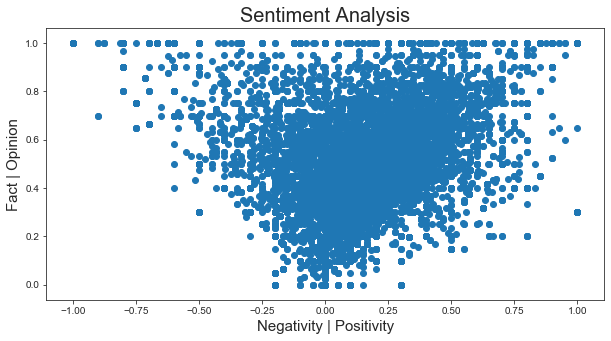

In [113]:
plt.figure(figsize=(10,5))

x = sentiment_df.textblob_polarity
y = sentiment_df.textblob_subjectivity
plt.scatter(x, y)
    
plt.title('Sentiment Analysis', fontsize=20)
plt.xlabel('Negativity | Positivity', fontsize=15)
plt.ylabel('Fact | Opinion', fontsize=15);

In [114]:
sentiment_df.head()

,tweet_id,created_at,screen_name,favorite_count,retweet_count,text,textblob_polarity,textblob_subjectivity,year
1,1230465254037037056,2020-02-20 12:12:32+00:00,lunchtimetecht1,1,1,ep events one year booksavailable wherever lis...,0.000000,0.000000,2020
3,1230144195362525184,2020-02-19 14:56:45+00:00,TheCapeTownGuy,34,6,announced new foldable phone cool …,0.243182,0.552273,2020
4,1230053630788530176,2020-02-19 08:56:53+00:00,Samsung_CafeBTM,0,0,get ready ortis deley gets handson three new c...,0.168182,0.477273,2020
5,1230020633259458560,2020-02-19 06:45:46+00:00,Flash_snaps,17,2,love buds😍😍thanks photo shot s…,0.500000,0.600000,2020
6,1229960553612763136,2020-02-19 02:47:02+00:00,DwijalDave,0,0,buds improves sound quality not one two optimi...,0.433333,0.433333,2020


## Time Series Analysis
Now that sentiment has been analyzed across the entire corpus, I will compare the most recent event to prior years. After identifying maxima and minima, I will take a closer look to see what conversations drove the positive/negative trends.

### View distribution

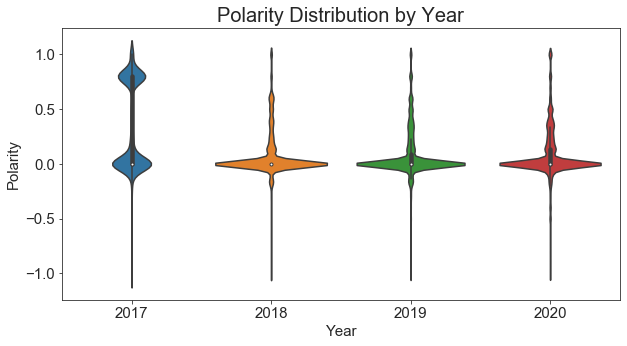

In [123]:
plt.figure(figsize=(10,5))

sns.violinplot(x='year', y='textblob_polarity', data=sentiment_df)
# sns.swarmplot(x='year', y='textblob_polarity', data=sentiment_df, color='white', edgecolor='gray')
plt.title('Polarity Distribution by Year', fontsize=20)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Polarity', fontsize=15)
plt.tick_params(labelsize=15)
plt.savefig('./images/plots/polarity_dist_year.png', transparent=True);

In [128]:
# create column to view the day of the tweet (rather than timestamp)
sentiment_df['day'] = sentiment_df['created_at'].dt.date
sentiment_df.head()

/Users/baka_brooks/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,tweet_id,created_at,screen_name,favorite_count,retweet_count,text,textblob_polarity,textblob_subjectivity,year,day
1,1230465254037037056,2020-02-20 12:12:32+00:00,lunchtimetecht1,1,1,ep events one year booksavailable wherever lis...,0.000000,0.000000,2020,2020-02-20
3,1230144195362525184,2020-02-19 14:56:45+00:00,TheCapeTownGuy,34,6,announced new foldable phone cool …,0.243182,0.552273,2020,2020-02-19
4,1230053630788530176,2020-02-19 08:56:53+00:00,Samsung_CafeBTM,0,0,get ready ortis deley gets handson three new c...,0.168182,0.477273,2020,2020-02-19
5,1230020633259458560,2020-02-19 06:45:46+00:00,Flash_snaps,17,2,love buds😍😍thanks photo shot s…,0.500000,0.600000,2020,2020-02-19
6,1229960553612763136,2020-02-19 02:47:02+00:00,DwijalDave,0,0,buds improves sound quality not one two optimi...,0.433333,0.433333,2020,2020-02-19


To compare the sentiment between each year, I will create a field comparing the timestamp of the tweet to the phone event of that year. This will yield the number of days before or after the event the tweet was posted.

In [169]:
# loop through each row and compare the event date to calculate days since event
days_since = []
for idx, year in enumerate(sentiment_df['year']):
    if year == 2020:
        event = dt.datetime.strptime('2020-02-11','%Y-%m-%d')
    elif year == 2019:
        event = dt.datetime.strptime('2019-02-20','%Y-%m-%d')
    elif year == 2018:
        event = dt.datetime.strptime('2018-02-25','%Y-%m-%d')
    elif year == 2017:
        event = dt.datetime.strptime('2017-03-29','%Y-%m-%d')
        
    days_diff = (sentiment_df['day'].iloc[idx] - event.date()).days
    days_since.append(days_diff)

In [174]:
sentiment_df['days_since'] = days_since
sentiment_df.head()

/Users/baka_brooks/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,tweet_id,created_at,screen_name,favorite_count,retweet_count,text,textblob_polarity,textblob_subjectivity,year,day,days_since
1,1230465254037037056,2020-02-20 12:12:32+00:00,lunchtimetecht1,1,1,ep events one year booksavailable wherever lis...,0.000000,0.000000,2020,2020-02-20,9
3,1230144195362525184,2020-02-19 14:56:45+00:00,TheCapeTownGuy,34,6,announced new foldable phone cool …,0.243182,0.552273,2020,2020-02-19,8
4,1230053630788530176,2020-02-19 08:56:53+00:00,Samsung_CafeBTM,0,0,get ready ortis deley gets handson three new c...,0.168182,0.477273,2020,2020-02-19,8
5,1230020633259458560,2020-02-19 06:45:46+00:00,Flash_snaps,17,2,love buds😍😍thanks photo shot s…,0.500000,0.600000,2020,2020-02-19,8
6,1229960553612763136,2020-02-19 02:47:02+00:00,DwijalDave,0,0,buds improves sound quality not one two optimi...,0.433333,0.433333,2020,2020-02-19,8


### Plot each year against pre & post launch windows

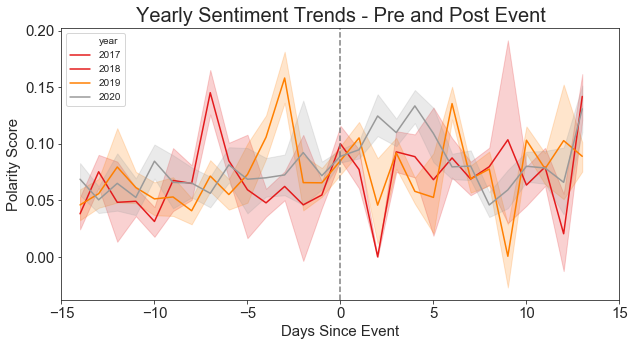

In [189]:
# plot the lineplots for each year
no_2017 = sentiment_df[sentiment_df['year'] != 2017]

plt.figure(figsize=[10,5])
sns.lineplot(x='days_since', y='textblob_polarity', hue='year', data=no_2017, palette='Set1')
plt.axvline(x=0, linestyle='--', color='gray')
plt.title('Yearly Sentiment Trends - Pre and Post Event', fontsize=20)
plt.xlabel('Days Since Event', fontsize=15)
plt.ylabel('Polarity Score', fontsize=15)
plt.tick_params(labelsize=15)
plt.xlim(-15, 15)
plt.legend()
plt.savefig('./images/plots/all_years_sentiment.png', transparent=True);

### Separate plots

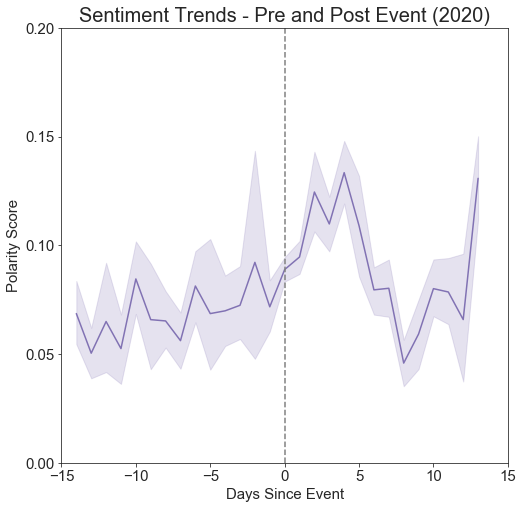

In [212]:
plt.figure(figsize=[8,8])
sns.lineplot(x='days_since', y='textblob_polarity', data=no_2017[no_2017['year'] == 2020], color=sns.color_palette("deep", 10)[4])
plt.axvline(x=0, linestyle='--', color='gray')
plt.title('Sentiment Trends - Pre and Post Event (2020)', fontsize=20)
plt.xlabel('Days Since Event', fontsize=15)
plt.ylabel('Polarity Score', fontsize=15)
plt.tick_params(labelsize=15)
plt.xlim(-15, 15)
plt.yticks(np.arange(0, 0.21, step=0.05))
plt.ylim(0, 0.2)
plt.savefig('./images/plots/sentiment_2020.png', transparent=True);

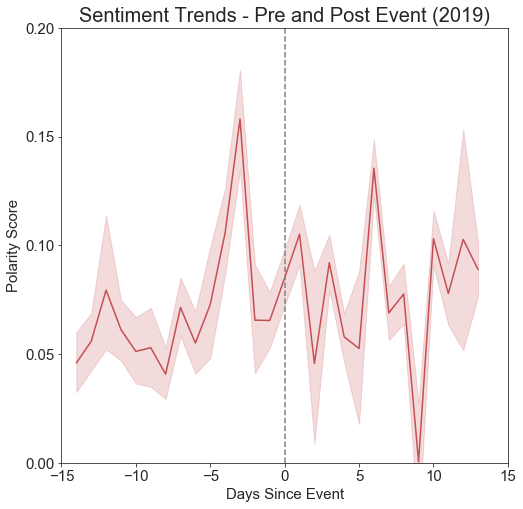

In [213]:
plt.figure(figsize=[8,8])
sns.lineplot(x='days_since', y='textblob_polarity', data=no_2017[no_2017['year'] == 2019], color=sns.color_palette("deep", 10)[3])
plt.axvline(x=0, linestyle='--', color='gray')
plt.title('Sentiment Trends - Pre and Post Event (2019)', fontsize=20)
plt.xlabel('Days Since Event', fontsize=15)
plt.ylabel('Polarity Score', fontsize=15)
plt.tick_params(labelsize=15)
plt.xlim(-15, 15)
plt.yticks(np.arange(0, 0.21, step=0.05))
plt.ylim(0, 0.2)
plt.savefig('./images/plots/sentiment_2019.png', transparent=True);

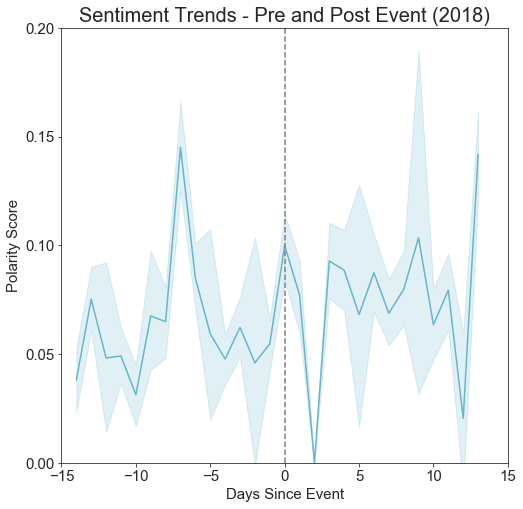

In [218]:
plt.figure(figsize=[8,8])
sns.lineplot(x='days_since', y='textblob_polarity', data=no_2017[no_2017['year'] == 2018], color=sns.color_palette("deep", 10)[9])
plt.axvline(x=0, linestyle='--', color='gray')
plt.title('Sentiment Trends - Pre and Post Event (2018)', fontsize=20)
plt.xlabel('Days Since Event', fontsize=15)
plt.ylabel('Polarity Score', fontsize=15)
plt.tick_params(labelsize=15)
plt.xlim(-15, 15)
plt.yticks(np.arange(0, 0.21, step=0.05))
plt.ylim(0, 0.2)
plt.savefig('./images/plots/sentiment_2018.png', transparent=True);

### Subplots

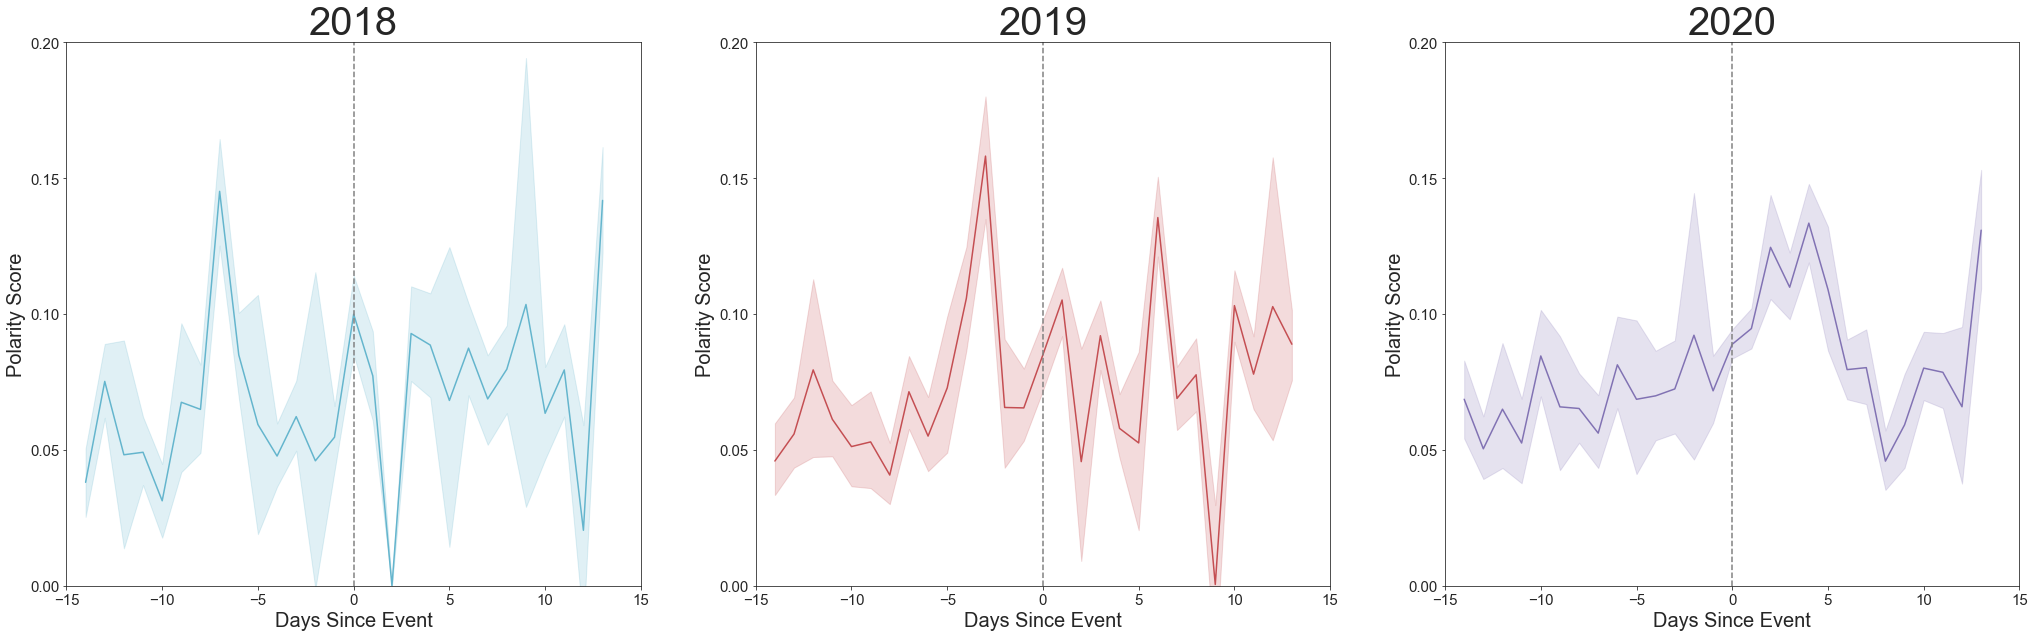

In [232]:
plt.figure(figsize=(35, 10))

plt.subplot(1, 3, 1)
sns.lineplot(x='days_since', y='textblob_polarity', data=no_2017[no_2017['year'] == 2018], color=sns.color_palette("deep", 10)[9])
plt.axvline(x=0, linestyle='--', color='gray')
plt.title('2018', fontsize=40)
plt.xlabel('Days Since Event', fontsize=20)
plt.ylabel('Polarity Score', fontsize=20)
plt.tick_params(labelsize=15)
plt.xlim(-15, 15)
plt.yticks(np.arange(0, 0.21, step=0.05))
plt.ylim(0, 0.2)

plt.subplot(1, 3, 2)
sns.lineplot(x='days_since', y='textblob_polarity', data=no_2017[no_2017['year'] == 2019], color=sns.color_palette("deep", 10)[3])
plt.axvline(x=0, linestyle='--', color='gray')
plt.title('2019', fontsize=40)
plt.xlabel('Days Since Event', fontsize=20)
plt.ylabel('Polarity Score', fontsize=20)
plt.tick_params(labelsize=15)
plt.xlim(-15, 15)
plt.yticks(np.arange(0, 0.21, step=0.05))
plt.ylim(0, 0.2)

plt.subplot(1, 3, 3)
sns.lineplot(x='days_since', y='textblob_polarity', data=no_2017[no_2017['year'] == 2020], color=sns.color_palette("deep", 10)[4])
plt.axvline(x=0, linestyle='--', color='gray')
plt.title('2020', fontsize=40)
plt.xlabel('Days Since Event', fontsize=20)
plt.ylabel('Polarity Score', fontsize=20)
plt.tick_params(labelsize=15)
plt.xlim(-15, 15)
plt.yticks(np.arange(0, 0.21, step=0.05))
plt.ylim(0, 0.2)

plt.savefig('./images/plots/all_sentiment_trends.png', transparent=True);